In [ ]:
# requirements.txt
!pip install tensorflow>=1.15.2
!pip install keras==2.3.1
!pip install numpy==1.18.2
!pip install opencv-python==4.2.0.*

     |████████████████████████████████| 378kB 21.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 20.2MB 1.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 28.2MB 78kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse

import cv2
import os

In [ ]:
# google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load our serialized face detector model from disk
face_detector_path = '/content/gdrive/MyDrive/Perkuliahan/af/face_detector'

print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([face_detector_path, "deploy.prototxt"])
weightsPath = os.path.sep.join([face_detector_path, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


In [ ]:
# load the face mask detector model from disk
model_path = '/content/gdrive/MyDrive/Perkuliahan/af/mask_detector.model'

print("[INFO] loading face mask detector model...")
model = load_model(model_path)

[INFO] loading face mask detector model...


[INFO] computing face detections...


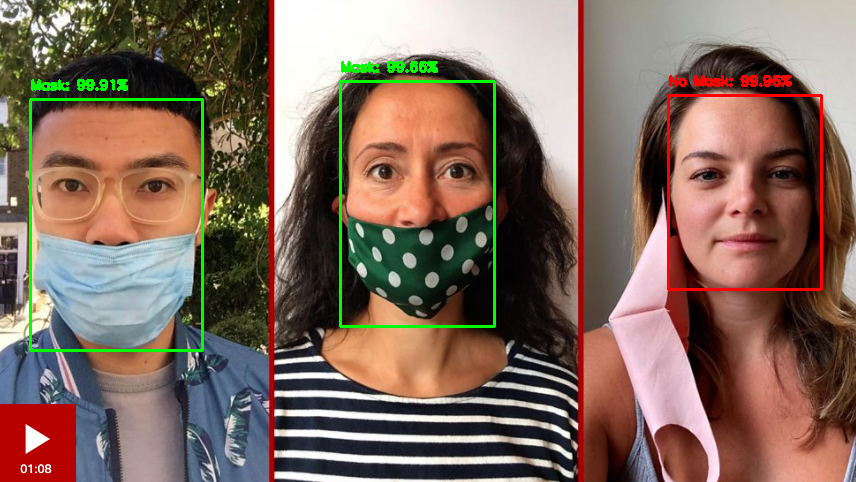

-1

In [ ]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions

image_path = '/content/gdrive/MyDrive/Perkuliahan/af/images/ex1.png'

image = cv2.imread(image_path)
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
		# the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
        (mask, withoutMask, incorrectlyMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text   

        # label = "Mask" if mask > withoutMask else "No Mask"

        if ((mask > withoutMask) and (mask > incorrectlyMask)):
            label = "Incorrectly Mask"
        elif ((withoutMask > incorrectlyMask) and (withoutMask > mask)):
            label = "Mask"
        else:
            label = "No Mask"
        
        if label == "Mask":
            color = (0, 255, 0)
        elif label =="No Mask":
            color = (0, 0, 255)
        else:
            color = (255, 140, 0)
        
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask, incorrectlyMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
        cv2.putText(image, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)